<a href="https://colab.research.google.com/github/vagarciar/TAM-2025-2/blob/main/lunes29sepCopia_de_Regresion_sinc_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Diego Luis Salazar Perlaza

Daniel Mauricio Mejía Hoyos

Luis Fernando Castro Buchelly

Julian David Morales Pineda

Valeria García Rodas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#función cálculo varianza del ruido a partir del snr dB
def var_snr(x,snrdB): #x vector de datos (señal), snrdB SNR en dB
    Px = np.mean(x**2)#estimador potencia media de la señal
    return Px/(10**(snrdB/10))

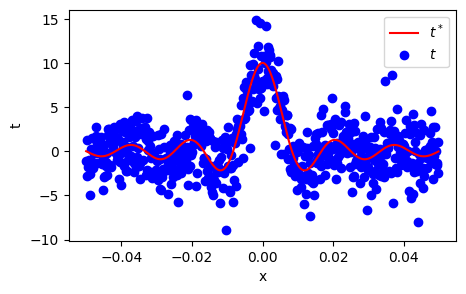

In [ ]:
#datos simulados
Fo = 60 #frecuencia fundamental señal cos
A = 10 # amplitud de la señal
To = 1/Fo #periodo fundamental
Fs = 100*Fo #frecuencia muestreo según nyquist Fs >= 2 Fo
X = np.arange(-3*To,3*To,1/Fs) #vector de entrada en un periodo con pasos según período de muestreo

snrdB = 2 #ruido según SNR dB
#señal limpia - objetivo
argumento = 2*np.pi*Fo*X
# Manejo de la división por cero en el punto X=0
tt = np.zeros_like(argumento)
non_zero_indices = argumento != 0
tt[non_zero_indices] = A * np.sin(argumento[non_zero_indices]) / argumento[non_zero_indices]
#modelo con función sinoidal contaminada con ruido Gaussiano
t = (A*np.sin(2*np.pi*Fo*X) + np.sqrt(var_snr(tt,snrdB))*np.random.randn(len(X)))/(2*np.pi*Fo*X)

potencia_ruido = var_snr(tt, snrdB)
ruido_gaussiano = np.sqrt(potencia_ruido) * np.random.randn(len(X))
t = tt + ruido_gaussiano

X = X.reshape(-1,1)#filas = realizaciones-muestras
t = t.reshape(-1,1)
tt = tt.reshape(-1,1)


plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t^*$')
plt.scatter(X,t,c='b',label='$t$')
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
# --- Split 70% train / 30% test ---
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, shuffle=True, random_state=42)


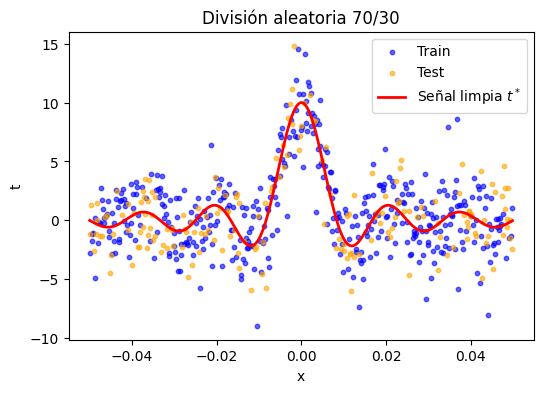

In [ ]:
# --- Visualización ---
plt.figure(figsize=(6,4))
plt.scatter(X_train, t_train, c="blue", s=10, alpha=0.6, label="Train")
plt.scatter(X_test, t_test, c="orange", s=10, alpha=0.6, label="Test")
plt.plot(X, tt, 'r', linewidth=2, label="Señal limpia $t^*$")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.title("División aleatoria 70/30")
plt.show()


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 10.8 MB/s eta 0:00:00


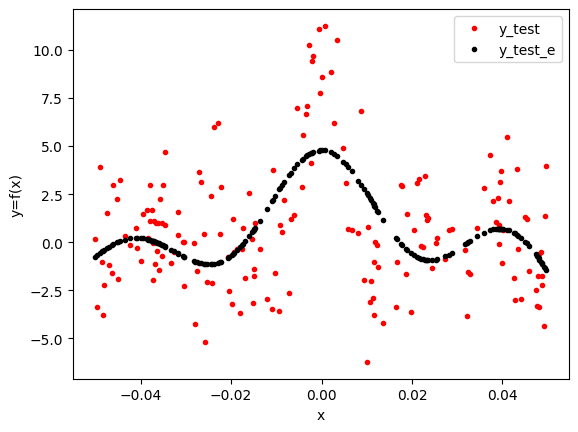

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline

alpha = 0.11895494784850819
gamma = 982.0709485294749
reg = KernelRidge(kernel='rbf',gamma=gamma, alpha = alpha)
reg.fit(X_train,t_train) #ajustar solo sobre train
#prediccion
y_test_e = reg.predict(X_test)
y_train_e = reg.predict(X_train)

plt.plot(X_test,t_test,'r.',label='y_test' )
plt.plot(X_test,y_test_e,'k.',label='y_test_e')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Regenerate simulated data (copying from cell lkbi7TSM79d_)
Fo = 60 #frecuencia fundamental señal cos
A = 10 # amplitud de la señal
To = 1/Fo #periodo fundamental
Fs = 100*Fo #frecuencia muestreo según nyquist Fs >= 2 Fo
X = np.arange(-3*To,3*To,1/Fs) #vector de entrada en un periodo con pasos según período de muestreo

snrdB = 2 #ruido según SNR dB
#señal limpia - objetivo
argumento = 2*np.pi*Fo*X
# Manejo de la división por cero en el punto X=0
tt = np.zeros_like(argumento)
non_zero_indices = argumento != 0
tt[non_zero_indices] = A * np.sin(argumento[non_zero_indices]) / argumento[non_zero_indices]
#modelo con función sinoidal contaminada con ruido Gaussiano
t = (A*np.sin(2*np.pi*Fo*X) + np.sqrt(var_snr(tt,snrdB))*np.random.randn(len(X)))/(2*np.pi*Fo*X)

# Assuming var_snr is defined in a previous cell or imported
# If not, you might need to copy the var_snr function definition as well.
# For now, assuming var_snr is available.
potencia_ruido = var_snr(tt, snrdB)
ruido_gaussiano = np.sqrt(potencia_ruido) * np.random.randn(len(X))
t = tt + ruido_gaussiano

X = X.reshape(-1,1)#filas = realizaciones-muestras
t = t.reshape(-1,1)
tt = tt.reshape(-1,1)


# Perform train-test split on the regenerated data
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, shuffle=True, random_state=42)


steps=[('reg', KernelRidge(kernel = 'rbf'))]
parameters = {'reg__alpha' : [0,1e-3,1e-2,0.1,1,10,100,1000],
              'reg__gamma': [1e-4,1e-3,1e-2,0.1,1,10,100,1000],
              }

pipeline = Pipeline(steps = steps)

grid_search = GridSearchCV(pipeline, parameters, n_jobs=4,cv=10,
                           scoring='neg_mean_absolute_error',verbose=10,refit=True)

# Reshape t_train to a 1D array
t_train_reshaped = t_train.ravel()

grid_search.fit(X_train, t_train_reshaped)
#mejor modelo entrenado
best_model = grid_search.best_estimator_

print("\nMejores parámetros:\n")
print(grid_search.best_params_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits

Mejores parámetros:

{'reg__alpha': 0.001, 'reg__gamma': 1000}


In [ ]:
import numpy as np
import optuna
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error



# --------------------------------------------------------------------------
# 3. OPTIMIZACIÓN BAYESIANA CON OPTUNA (¡Aquí está la nueva lógica!)
# --------------------------------------------------------------------------

# Se define la "función objetivo" que Optuna intentará minimizar.
# Esta función encapsula todo el proceso: crear modelo, entrenarlo y evaluarlo.
def objective(trial):
    # 1. Sugerir hiperparámetros para este "trial" (intento)
    # Optuna elegirá valores de forma inteligente dentro de estos rangos.
    alpha = trial.suggest_float('alpha', 1e-3, 1e3, log=True)
    gamma = trial.suggest_float('gamma', 1e-3, 1e3, log=True)

    # 2. Crear el modelo con los hiperparámetros sugeridos
    model = KernelRidge(kernel='rbf', alpha=alpha, gamma=gamma)

    # 3. Evaluar el modelo usando Validación Cruzada (¡la forma correcta!)
    # Esto evita usar el conjunto de test para la optimización.
    # Usamos el error cuadrático medio negativo porque Optuna minimiza por defecto.
    score = cross_val_score(model, X_train, t_train_reshaped, cv=10, scoring='neg_mean_squared_error')

    # 4. Devolver el promedio del error de la validación cruzada
    # Como el score es negativo, devolvemos su promedio.
    return np.mean(score)

# 1. Crear un "estudio" de Optuna. La meta es maximizar el score (que es negativo).
# Por lo tanto, usamos direction='maximize'.
study = optuna.create_study(direction='maximize')

# 2. Iniciar la optimización. Optuna llamará a la función 'objective' 40 veces.
study.optimize(objective, n_trials=40)


# --------------------------------------------------------------------------
# 4. OBTENCIÓN DE RESULTADOS
# --------------------------------------------------------------------------
print("Optimización con Optuna finalizada.")
print(f"Número de trials finalizados: {len(study.trials)}")

print("\nMejor trial:")
best_trial = study.best_trial
# El valor del score es negativo, lo multiplicamos por -1 para ver el MSE real
print(f"  Valor (MSE): {-best_trial.value:.6f}")
print("  Mejores Parámetros: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Entrenar el modelo final con los mejores parámetros encontrados en TODO el set de entrenamiento
best_params = study.best_params
final_model = KernelRidge(kernel='rbf', **best_params)
final_model.fit(X_train, t_train_reshaped)

# Evaluar el modelo final en el conjunto de test (que nunca fue usado en la optimización)
final_score = final_model.score(X_test, t_test)
print(f"\nR^2 score del modelo final en el conjunto de test: {final_score:.4f}")

[I 2025-09-29 20:41:53,377] A new study created in memory with name: no-name-7bd360f8-5f81-4a31-9bed-fc0c3c45b7bd
[I 2025-09-29 20:41:54,555] Trial 0 finished with value: -11.825290207398067 and parameters: {'alpha': 0.005136661143521656, 'gamma': 0.008411759608081}. Best is trial 0 with value: -11.825290207398067.
[I 2025-09-29 20:41:55,860] Trial 1 finished with value: -11.82764459759742 and parameters: {'alpha': 0.004702603572113559, 'gamma': 0.05736677102510948}. Best is trial 0 with value: -11.825290207398067.
[I 2025-09-29 20:41:56,453] Trial 2 finished with value: -11.822576824896094 and parameters: {'alpha': 8.757495225639735, 'gamma': 0.2690599548940148}. Best is trial 2 with value: -11.822576824896094.
[I 2025-09-29 20:41:57,000] Trial 3 finished with value: -11.821409426729987 and parameters: {'alpha': 35.60994458944793, 'gamma': 2.196763872293753}. Best is trial 3 with value: -11.821409426729987.
[I 2025-09-29 20:41:57,127] Trial 4 finished with value: -10.713839315432596 a

Optimización con Optuna finalizada.
Número de trials finalizados: 40

Mejor trial:
  Valor (MSE): 7.981841
  Mejores Parámetros: 
    alpha: 0.11895494784850819
    gamma: 982.0709485294749

R^2 score del modelo final en el conjunto de test: 0.2407


In [ ]:
from sklearn.datasets import fetch_california_housing
N = 1000 # # samples
P = 20 # # features
X, y = fetch_california_housing(return_X_y=True)
print(X.shape,y.shape)

(20640, 8) (20640,)


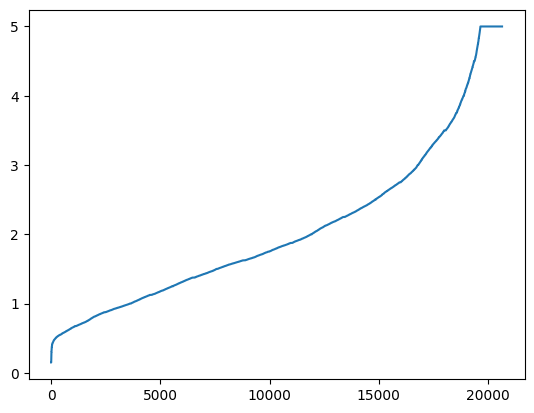

In [ ]:
plt.plot(np.sort(y))
plt.show()

In [ ]:
from sklearn.linear_model import BayesianRidge
br = BayesianRidge(compute_score=True)  # ajusta lambdas automáticamente
br.fit(X_train, t_train.ravel())
y_pred = br.predict(X_test)
# obtener incertidumbre aproximada (std) no directamente en sklearn; para eso usar PyMC o GPR


NameError: name 'X_train' is not defined

Dimensiones de X (Ingreso Medio) California Housing: (20640, 1)
Dimensiones de y (Valor de la Vivienda) California Housing: (20640,)


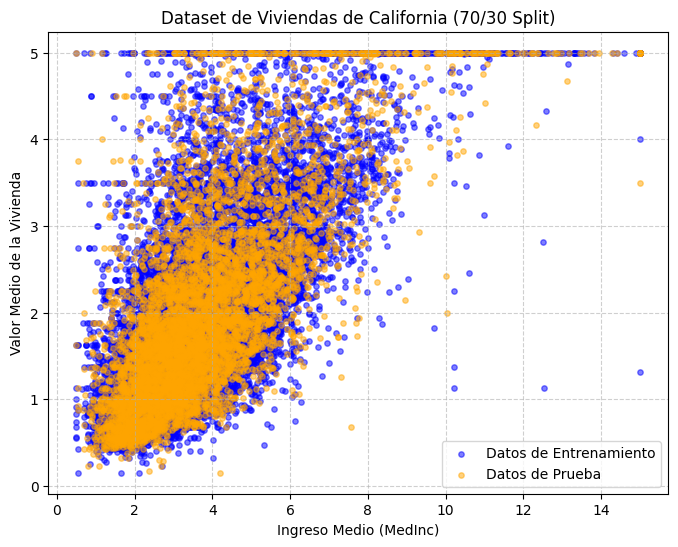

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# --- 1. Cargar y preparar el dataset ---
# Cargamos el dataset de California Housing
X_full_cal, y_cal = fetch_california_housing(return_X_y=True)

# Para poder visualizar en 2D, seleccionamos solo una característica: el Ingreso Medio (MedInc).
# Esta es la primera columna (índice 0).
X_cal = X_full_cal[:, 0].reshape(-1, 1)

print(f"Dimensiones de X (Ingreso Medio) California Housing: {X_cal.shape}")
print(f"Dimensiones de y (Valor de la Vivienda) California Housing: {y_cal.shape}")

# --- 2. División 70% entrenamiento / 30% prueba ---
# Use different variable names to avoid conflict with simulated data split
X_train_cal, X_test_cal, y_train_cal, y_test_cal = train_test_split(X_cal, y_cal, test_size=0.3, random_state=42)

# --- Visualización inicial de los datos ---
plt.figure(figsize=(8, 6))
plt.scatter(X_train_cal, y_train_cal, c="blue", s=15, alpha=0.5, label="Datos de Entrenamiento")
plt.scatter(X_test_cal, y_test_cal, c="orange", s=15, alpha=0.5, label="Datos de Prueba")
plt.xlabel("Ingreso Medio (MedInc)")
plt.ylabel("Valor Medio de la Vivienda")
plt.title("Dataset de Viviendas de California (70/30 Split)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()